## A very dirty but quick analysis of resting state networks on Gordon2014 atlas

In [48]:
from python.acnets.pipeline.parcellation import Parcellation
import pandas as pd
import numpy as np
import pygal as pg

In [52]:
p = Parcellation('gordon2014_2mm').fit()

_timeseries_list = []

for ts in p.dataset_['timeseries']:
  subj_ts = {
    'timeseries': [t for t in ts.values.T],
    'network': p.dataset_['network'].to_series()
  }
  subj_ts = pd.DataFrame(subj_ts)
  subj_ts['subject'] = ts['subject'].values
  
  _timeseries_list.append(subj_ts)

_timeseries = pd.concat(_timeseries_list).reset_index()
network_timeseries = _timeseries.groupby(['network','subject'])['timeseries'].apply(
  lambda ts: np.mean(ts)).to_frame().rename(columns={'timeseries': 'timeseries_mean'})
network_timeseries

timeseries_mean
network  subject                                                     
Auditory AVGP01     [0.155050518377091, -0.42787016114734816, -0.1...
         AVGP02     [1.0987179895927723, 0.19314389418244046, -0.5...
         AVGP03     [0.06212536520085069, 0.024480672613347947, -0...
         AVGP04     [0.2718988901929729, 0.184475336337972, -0.439...
         AVGP05     [0.9352400819412211, 0.36607750828785396, -0.8...
...                                                               ...
Visual   NVGP16     [0.3078102776202242, -0.10895733786197369, -0....
         NVGP17     [-0.6687481558602973, -0.44582095126189014, -0...
         NVGP17NEW  [0.7034746425472597, -0.2575508721376037, -0.5...
         NVGP19     [1.0061502559839068, -0.3029705123366826, -0.2...
         NVGP19NEW  [-0.7325677649883063, -0.05339914974153185, 0....

[416 rows x 1 columns]

In [53]:

def group_network_timeseries_by_subject(net_ts):
  # mean_net_ts = mean_net_ts.to_frame().query('index.get_level_values(1) == "AVGP03"')
  subjs_nets = net_ts.groupby('subject')['timeseries_mean'].apply(list)
  ts = [np.array(s).T for s in subjs_nets]
  lbl = net_ts.index.get_level_values(0).unique()
  return ts, lbl


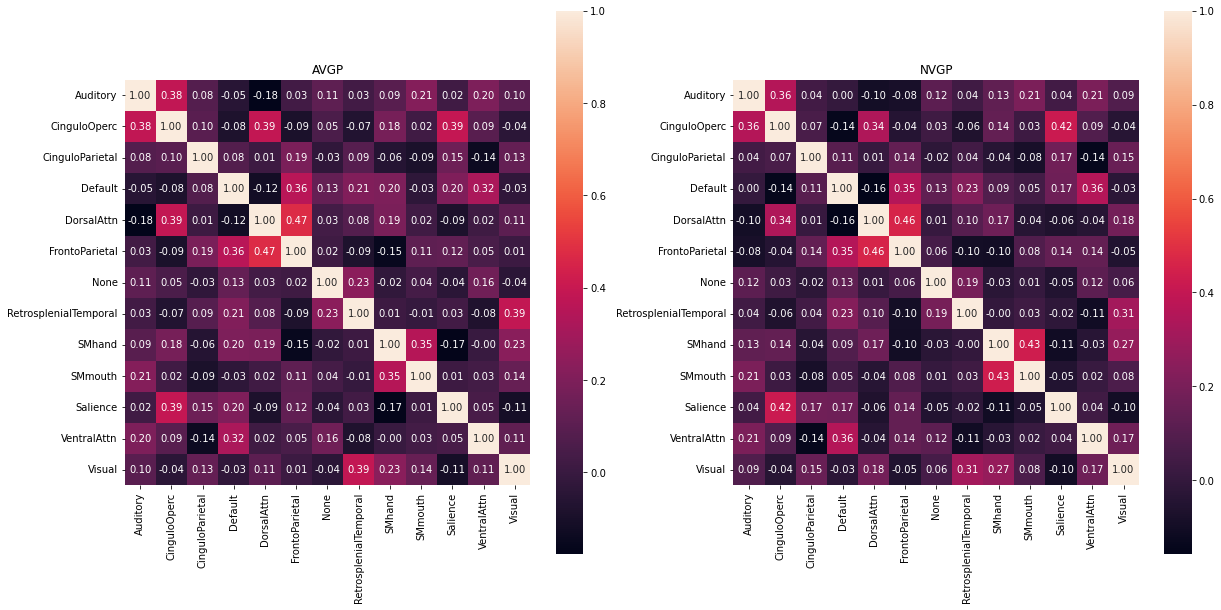

In [55]:
from python.acnets.connectome import ExtraConnectivityMeasure
conn = ExtraConnectivityMeasure(kind='partial correlation', vectorize=False)
import seaborn as sns
import matplotlib.pyplot as plt

_, axes = plt.subplots(1, 2, figsize=(20,10))

# AVGP
avgp = network_timeseries.query('subject.str.contains("AVGP")')
ts, lbl = group_network_timeseries_by_subject(avgp)

avgp_conn_mean = conn.fit_transform(ts).mean(axis=0)

sns.heatmap(avgp_conn_mean,
            ax=axes[0],
            square=True, annot=True, fmt='.2f', xticklabels=lbl, yticklabels=lbl)
axes[0].set_title('AVGP')

# NVGP
nvgp = network_timeseries.query('subject.str.contains("NVGP")')
ts, lbl = group_network_timeseries_by_subject(nvgp)
nvgp_conn_mean = conn.fit_transform(ts).mean(axis=0)

sns.heatmap(nvgp_conn_mean,
            ax=axes[1],
            square=True, annot=True, fmt='.2f', xticklabels=lbl, yticklabels=lbl)
axes[1].set_title('NVGP')
plt.show()

In [57]:
chart = pg.Line(_self_close=False, _max=10)

for (network,subject),data  in network_timeseries['timeseries_mean'].iteritems():
  if network in ['Visual','FrontoParietal']:
    chart.add(network, data)

from IPython.display import SVG
SVG(chart.render())

# Again, a very dirty but quick EPI signal level in Cerebellum

Is it clear that there is an appreciable reduction of tSNR in the brainstem and cerebellum compared to the cerebrum, caused by lower mean signal and/or increased signal variance in the those regions (as measured by tSNR)?

In [ ]:
from nilearn import image, plotting
import nibabel as nib 
from pathlib import Path
import datalad.api as dlapi

tsnr_images = []

dataset = dlapi.Dataset('data/julia2018/derivatives/fmriprep_2020')
# sub-AVGP01_ses-rest_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold

scan_imgs  = Path(dataset.path).glob('sub-*/ses-rest/func/*_bold.nii.gz')

for img in scan_imgs:
  dlapi.get(img)
  subj_rs_img = nib.load(img)

  data_avg = np.mean(subj_rs_img.get_fdata(), axis=-1)
  data_std = np.std(subj_rs_img.get_fdata(), axis=-1)
  tsnr = data_avg / data_std
  tsnr = np.where(data_std > 0.0, tsnr, 0.0)
  tsnr_img = nib.nifti1.Nifti1Image(tsnr, subj_rs_img.affine)

  tsnr_images.append(tsnr_img)

tsnr_images = nib.concat_images(tsnr_images)
mean_tsnr_img = image.mean_img(tsnr_images)


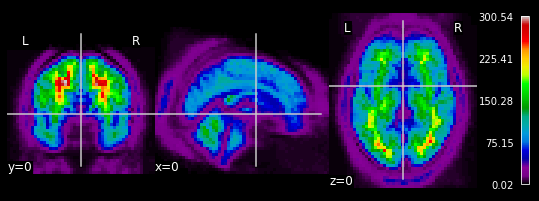

In [146]:
plotting.plot_epi(mean_tsnr_img, colorbar=True,
                  cut_coords=(0,0,0),
                  cbar_tick_format='%.2f')
plt.show()

## Dirty Network masker

In [131]:
from nilearn import maskers, datasets, plotting, image, surface
import numpy as np
from python.acnets.parcellations import gordon

atlas = gordon.fetch_atlas()

maps_data = image.get_data(atlas['maps'])
atlas.labels['network'] = atlas.labels['network'].astype('category')
region2network_mapping = atlas.labels['network'].cat.codes + 1
region2network_mapping = region2network_mapping.to_dict()
# atlas.labels['network'].cat.categories
none_regions = atlas.labels.query('network == "None"').index
none_idx = atlas.labels['network'].cat.categories.to_list().index('None') + 1
map_r2n = lambda x: region2network_mapping[int(x)] if x not in [0,none_idx] else 0
maps_data = np.vectorize(map_r2n)(maps_data)

new_maps = image.new_img_like(atlas['maps'], maps_data)
new_maps.to_filename('a.nii.gz')

fsaverage = datasets.fetch_surf_fsaverage()

# plotting.plot_epi(new_maps, colorbar=True)
# plotting.plot_img(new_maps, colorbar=True)
# plotting.plot_roi(new_maps, title='Gordon Atlas', colorbar=True)

# aa = surface.vol_to_surf(new_maps, fsaverage.pial_left)

# plotting.view(fsaverage['pial_left'], roi_map=aa,
#                        hemi='left', view='lateral',
#                        bg_map=fsaverage['sulc_left'], bg_on_data=True,
#                        darkness=.5)

plotting.view_img(new_maps, symmetric_cmap=False).open_in_browser()

# plotting.view_surf(fsaverage.white_right, aa).open_in_browser()
# plotting.plot_glass_brain(new_maps, colorbar=True, annotate=True)
# plotting.plot_epi(net_maps,cut_coords=(0,-10,-55), colorbar=True)

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [105]:
atlas.labels['network'].cat.categories

Index(['Auditory', 'CinguloOperc', 'CinguloParietal', 'Default', 'DorsalAttn',
       'FrontoParietal', 'None', 'RetrosplenialTemporal', 'SMhand', 'SMmouth',
       'Salience', 'VentralAttn', 'Visual'],
      dtype='object')